# Practice Session 03: Find near-duplicates using shingling

Author: <font color="blue">Rubén Vera Martínez</font>

E-mail: <font color="blue">ruben.vera01@estudiant.upf.edu</font>

Date: <font color="blue">14/10/22</font>

In [35]:
import io
import json
import gzip
import re
import random
import numpy as np
import matplotlib.pyplot as plt
from timeit import default_timer as timer
import datetime

In [36]:
# Input file
INPUT_FILENAME = "CovidLockdownCatalonia.json.gz"

# Array for storing messages
messages = []
MAX_MESSAGES = 10000

with gzip.open(INPUT_FILENAME, "rt", encoding="utf-8") as input_file:
    
    messages_read = 0
    for line in input_file:
            
        # Read message
        tweet = json.loads(line)

        # Keep only messages in Catalan
        if tweet["lang"] == "ca":
            
            messages_read += 1
            
            if messages_read <= MAX_MESSAGES:
                author = tweet["user"]["screen_name"]
                message = tweet["full_text"]
                messages.append(message)

print("Read %d documents" % len(messages))

Read 10000 documents


# 1. Auxiliary functions

In [37]:
def jaccard_similarity(set1, set2):
    #First, we declare set to what enters to function to avoid errors.
    set1 = set(set1)
    set2 = set(set2)
    #Now, apply the formula intersection/union using the functions .intersection and .union
    nominator = set1.intersection(set2)
    denominator = set1.union(set2)
    #To avoid issues of type denominator = 0, if denominator = 0 we just return 0. Otherwise, we'll return the value of
    #Similarity
    if(len(denominator) == 0):
        return 0
    similarity = len(nominator)/len(denominator)
    return similarity

In [38]:
#We do 4 tests expecting jaccard_similarity 0.6666, 0.75, 1 and 0 respectively to see if function is working correctly.
A = {1, 2, 4, 8, 7}
B = {1, 2, 4, 8, 9}
print(jaccard_similarity(A,B))
A = {1, 2, 3, 4}
B = {1, 2, 3}
print(jaccard_similarity(A,B))
A = {1, 2, 4, 8, 9}
B = {1, 2, 4, 8, 9}
print(jaccard_similarity(A,B))
A = set()
B = set()
print(jaccard_similarity(A,B))


0.6666666666666666
0.75
1.0
0


In [39]:
def clean(text):
    #Using "re" library, we clean the text as follows:
    #First, delete the RT that is showed when you Retweet something, to just get the message
    text = re.sub('RT ', '', text)
    #Transform all upercase letters to lowercase.
    text = text.lower()
    #Romanizing text avoiding accent marks and other letters not allowed.
    text = re.sub('Ñ', 'n', text)
    text = re.sub('ñ', 'n', text)
    text = re.sub('é', 'e', text)
    text = re.sub('è', 'e', text)
    text = re.sub('ò', 'o', text)
    text = re.sub('ú', 'u', text)
    text = re.sub('ç', 'c', text)
    text = re.sub('í', 'i', text)
    text = re.sub('ó', 'o', text)
    text = re.sub('à', 'a', text)
    text = re.sub('l·l', 'll', text)
    #Delete URLs, we delete all that have https and so on till a space
    text = re.sub(r'\S*https?:\S*', '', text)
    #Remove spaces at first and at the end of a message with strip function
    text.strip()
    #Remove all that are not letters, numbers or spaces
    text = re.sub(r'[^A-Za-z0-9 ]+', '', text)
    #Transform more than 1 space to just 1.
    text = re.sub(" +", " ", text)
    return text

In [40]:
#We do some tests to know whether the function is working correctly or not.
text1 = "RT hi"
text1 = clean(text1)
print(text1)

text2 = " hiñÑó´ql·l "
text2 = clean(text2)
print(text2)

text3 = "https://en.wikipedia.org/wiki/Romanization#Transcription hi"
text3 = clean(text3)
print(text3)

text4 = "A & A&&l"
text4 = clean(text4)
print(text4)

text5 = "a                    hi"
text5 = clean(text5)
print(text5)

hi
 hinnoqll 
 hi
a al
a hi


# 2. Implement an n-gram extractor

In [41]:
MIN_TOKEN_LENGTH = 2

def ngrams(text, size):
    tokens = clean(text).split()
    ngrams = []
    temp = []
    for i in range(0, len(tokens)):
        #We check all possible tokens and if they are words of more than MIN_TOKEN_LENGTH
        if(len(tokens[i]) >= MIN_TOKEN_LENGTH):
                #If they are, add them to a temporal list
                temp.append(tokens[i])
    
    for j in range(len(temp)-size+1):
        #We convert all accepted words to ngrams of size = size so,
        #we get the j:j+size words and put them as an ngram which means, separated by a space
        ngram = ' '.join(temp[j:j+size])
        #once we get the ngram we add it to ngrams list
        ngrams.append(ngram)
    return ngrams

In [42]:
print(messages[9780])
print(ngrams(messages[9780], 2))

RT @diariARA: Comerciants xinesos donen mascaretes i gel antisèptic a Badalona per lluitar contra el coronavirus https://t.co/ybYXFxphIu
['diariara comerciants', 'comerciants xinesos', 'xinesos donen', 'donen mascaretes', 'mascaretes gel', 'gel antiseptic', 'antiseptic badalona', 'badalona per', 'per lluitar', 'lluitar contra', 'contra el', 'el coronavirus']


# 3. Estimation for brute force method

In [43]:
# LEAVE AS-IS

def time_brute_force_similarities(messages, limit, ngram_size):
    if limit > len(messages):
        raise ValueError("Limit should be less than or equal than the number of messages")
        
    # Start a timer
    start = timer()

    # Iterate through document identifiers
    for docid1 in range(np.min([len(messages), limit])):

        # Clean document 1 and extract ngrams
        doc1 = clean(messages[docid1])
        ngrams1 = ngrams(doc1, ngram_size)

        # Iterate through document identifiers larger than doc2
        for docid2 in range(docid1+1, np.min([len(messages), limit])):
                         
            # Clean document 2 and extract ngrams
            doc2 = clean(messages[docid2])
            ngrams2 = ngrams(doc2, ngram_size)

            # Compute similarity
            similarity = jaccard_similarity(ngrams1, ngrams2)

    end = timer()
    return(end - start)

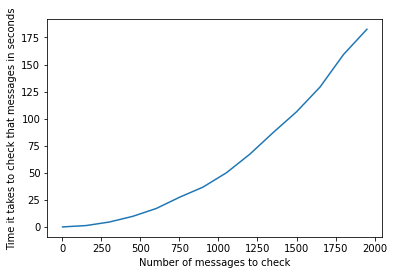

In [81]:
temp = []
#We calculate time to check messages with the function
for i in range(1,2001,150):
    temp.append(time_brute_force_similarities(messages, i, 3))

#Define values of axis
y = temp
x = range(1,2001,150)

plt.plot(x,y)
#Define the labels of the axis
plt.xlabel("Number of messages to check")
plt.ylabel("Time it takes to check that messages in seconds")
plt.show()

We can clearly see that it follows an exponential function, so the more messages it has to check the more it takes to check them. We can see that for 1000 messages it needs around 45 seconds, so for 10000 messages(size of the matrix) it would take around 450 seconds if it was a constant growing line, but as it is exponential, it would use approximately 600 seconds, which are 10 minutes.


# 4. Computing the doc-ngram matrix

## 4.1 Create list of all ngrams

In [45]:
#Initialize dictionaries and values
NGRAM_SIZE = 3
ngram_to_index = {}
index_to_ngram = {}
next_index = 0
for message in messages:
    all_ngrams = ngrams(message, NGRAM_SIZE)
    for ngram in all_ngrams:
        #For all ngrams, if they're not in ngrams list yet, we go on.
        if(ngram not in ngram_to_index):
            #Once the ngram it's accepted, we store his index in ngram_to_index with the name of ngram as a key
            ngram_to_index[ngram] = next_index
            #then we store the ngram with the index as a key in index_to_ngram.
            index_to_ngram[next_index] = ngram
            #Now, we sum 1 to the index
            next_index += 1

num_distinct_ngrams = next_index
print("There are %d distinct ngrams in the %d documents" % (num_distinct_ngrams, len(messages)))
    

There are 67077 distinct ngrams in the 10000 documents


In [46]:
#Used this cell to test the resultant dictionaries were correct.
index1 = ngram_to_index["tancat escoles fins"]
print(ngram_to_index["tancat escoles fins"])
print(index_to_ngram[index1])

index = ngram_to_index["garantir la seguretat"]
print(ngram_to_index["garantir la seguretat"])
print(index_to_ngram[index])

939
tancat escoles fins
34
garantir la seguretat


## 2.2 Create table ngrams x documents

In [47]:
# LEAVE AS-IS

# Create dense matrix in which every cell contains the value "False"
M_ngram_doc = np.full((num_distinct_ngrams, len(messages)), False)

# Print the number of rows and columns of this matrix
# numpy.matrix.shape is a tuple, shape[0] is the number of rows, shape[1] the number of columns
print("Matrix dimensions: %d rows (distinct shingles) x %d columns (distinct documents)" % M_ngram_doc.shape)

Matrix dimensions: 67077 rows (distinct shingles) x 10000 columns (distinct documents)


In [48]:
for docid in range(len(messages)):
    #We put the ngrams of a doc as a True in M_ngram_doc
    message = messages[docid]
    all_ngrams = ngrams(message, 3)
    for ngram in all_ngrams:
        #We get the index of the ngram to know where it is on M_ngram_doc
        i = ngram_to_index[ngram]
        #Then in position i(ngram position) docid(id of the doc, its position in matrix) we put a True value.
        M_ngram_doc[i, docid] = True


In [49]:
#We count nombers of nonzero(Trues) of the matrix with numpy function count_nonzero().
nonzero = np.count_nonzero(M_ngram_doc)
#Number of cells will be M*N of the matrix
n_cells = M_ngram_doc.shape[0]*M_ngram_doc.shape[1]
#Then, we calculate the density of the matrix
print("Density of M_ngram_doc matrix is: ", nonzero/n_cells*100)

Density of M_ngram_doc matrix is:  0.023286968707604692


In [71]:
col9602 = []
col941 = []

for i in range(len(M_ngram_doc[:,9602])):
    #We search all the ngrams in doc 9602 which means a True value in matrix M_ngram_doc
    if(M_ngram_doc[i,9602])>0:
        #If the ngram is in doc, add it to col9602 list which will contain all the ngrams of the doc
        col9602.append(str(i) + ' (' + str(index_to_ngram[i]) + ')')
        
#Same for the doc 941
for i in range(len(M_ngram_doc[:,941])):
    if(M_ngram_doc[i,941])>0:
        col941.append(str(i) + ' (' + str(index_to_ngram[i]) + ')')

print("Clean message of docid 9602:\n", clean(messages[9602]))
print("Positions of non-zeros in column of docid 9602 of M_ngram_doc is:\n\n ", col9602, "\n")

print("Clean message of docid 941:\n", clean(messages[941]))
print("Positions of non-zeros in column of docid 941 of M_ngram_doc is:\n\n ", col941)

Clean message of docid 9602:
 emergenciescat que puc fer i que no faqs del coronavirus a 14 de marc si us plau demanem difusio 
Positions of non-zeros in column of docid 9602 of M_ngram_doc is:

  ['911 (si us plau)', '1222 (emergenciescat que puc)', '1223 (que puc fer)', '1224 (puc fer que)', '1225 (fer que no)', '2574 (14 de marc)', '39144 (que no faqs)', '39145 (no faqs del)', '39146 (faqs del coronavirus)', '39147 (del coronavirus 14)', '39148 (coronavirus 14 de)', '39149 (de marc si)', '39150 (marc si us)', '39151 (us plau demanem)', '39152 (plau demanem difusio)'] 

Clean message of docid 941:
 hospiolot usem de forma responsable els recursos sanitaris061 urgencies per coronavirus i sanitaries012 consultes general
Positions of non-zeros in column of docid 941 of M_ngram_doc is:

  ['1476 (usem de forma)', '1477 (de forma responsable)', '1478 (forma responsable els)', '1479 (responsable els recursos)', '1480 (els recursos sanitaris061)', '1481 (recursos sanitaris061 urgencies)', '

# 3. Implement a permutation generator

In [72]:
def random_permutation(k):
    #Initialize the sequence of possible values of the permutation
    sequence = list(range(0,k))
    #Shuffle them to create a random permutation
    random.shuffle(sequence)
    return sequence

In [73]:
# LEAVE AS-IS

# Permute a list according to a permutation
def permuter(original_list, permutation):
    permuted_list = []
    for index in permutation:
        permuted_list.append(original_list[index])
    return permuted_list

# Code for testing permutations
original_list_1 = ["1 (ek)", "2 (do)", "3 (tīn)", "4 (chār)", "5 (pāṅc)"]
original_list_2 = ["1 (jedan)", "2 (dva)", "3 (tri)", "4 (četiri)", "5 (pet)"]

print("Test one permutation:")
permutation_1 = random_permutation(5)
print(permuter(original_list_1, permutation_1))
print(permuter(original_list_2, permutation_1))

print()

print("Test another permutation")
permutation_2 = random_permutation(5)
print(permuter(original_list_1, permutation_2))
print(permuter(original_list_2, permutation_2))

Test one permutation:
['5 (pāṅc)', '3 (tīn)', '4 (chār)', '2 (do)', '1 (ek)']
['5 (pet)', '3 (tri)', '4 (četiri)', '2 (dva)', '1 (jedan)']

Test another permutation
['3 (tīn)', '1 (ek)', '5 (pāṅc)', '2 (do)', '4 (chār)']
['3 (tri)', '1 (jedan)', '5 (pet)', '2 (dva)', '4 (četiri)']


# 4. Compute the signature of each document

In [74]:
# Leave this code as-is

NUM_PERMUTATIONS = 5

permutations = []

# Create the permutations
for i in range(NUM_PERMUTATIONS):
    permutation = random_permutation(num_distinct_ngrams)
    permutations.append(random_permutation(num_distinct_ngrams))
    
# Visualize the permutations by printing their first 3 elements
for i in range(len(permutations)):
    permutation = permutations[i]
    print("Permutation %d: %d, %d, %d, ..." % (i, permutation[0], permutation[1], permutation[2] ))

Permutation 0: 36301, 12562, 21648, ...
Permutation 1: 41649, 2292, 49921, ...
Permutation 2: 62133, 32350, 31997, ...
Permutation 3: 45787, 2881, 8050, ...
Permutation 4: 15436, 44102, 56362, ...


In [75]:
M_signature_doc = np.full((NUM_PERMUTATIONS, len(messages)), np.nan)
# Find the first ngram in a document, according to a permutation
def find_first_one(docid, permutation):
    for shingle_id in permutation:
        if M_ngram_doc[shingle_id, docid] == True:
            return shingle_id
    return -1

# Create permutations
for permutation_num in range(NUM_PERMUTATIONS):
    print("Creating signatures for permutation %d/%d" % (permutation_num+1, NUM_PERMUTATIONS))
    permutation = permutations[permutation_num]
    for docid in range(len(messages)):
        if docid % 1000 == 0:
            print("- Scanning document %d of %d" % (docid, len(messages)))
        M_signature_doc[permutation_num,docid]= find_first_one(docid, permutation)


Creating signatures for permutation 1/5
- Scanning document 0 of 10000
- Scanning document 1000 of 10000
- Scanning document 2000 of 10000
- Scanning document 3000 of 10000
- Scanning document 4000 of 10000
- Scanning document 5000 of 10000
- Scanning document 6000 of 10000
- Scanning document 7000 of 10000
- Scanning document 8000 of 10000
- Scanning document 9000 of 10000
Creating signatures for permutation 2/5
- Scanning document 0 of 10000
- Scanning document 1000 of 10000
- Scanning document 2000 of 10000
- Scanning document 3000 of 10000
- Scanning document 4000 of 10000
- Scanning document 5000 of 10000
- Scanning document 6000 of 10000
- Scanning document 7000 of 10000
- Scanning document 8000 of 10000
- Scanning document 9000 of 10000
Creating signatures for permutation 3/5
- Scanning document 0 of 10000
- Scanning document 1000 of 10000
- Scanning document 2000 of 10000
- Scanning document 3000 of 10000
- Scanning document 4000 of 10000
- Scanning document 5000 of 10000
- Sca

In [76]:
# Leave this code as-is

def extract_ngrams(docid):
    return [x for x in range(num_distinct_ngrams) if M_ngram_doc[x, i] == True]

def extract_signature(docid):
    return [M_signature_doc[x, docid] for x in range(NUM_PERMUTATIONS)]

def print_sig(messages, M_ngram_doc, M_signature_doc, i):
    print("Document #%d" % i)
    print("Message       : %s" % messages[i])
    print("Clean message : %s" % clean(messages[i]))
    print("Ngrams        : %s" % extract_ngrams(i))
    print("Signature     : %s" % extract_signature(i))

        
i = 385
j = 627

print_sig(messages, M_ngram_doc, M_signature_doc, i )

print()

print_sig(messages, M_ngram_doc, M_signature_doc, j )

Document #385
Message       : RT @gencat: 🔴 El @govern de la @gencat anuncia el #confinament de tot Catalunya.

Davant l’emergència de la #COVID19, el missatge és clau:…
Clean message : gencat el govern de la gencat anuncia el confinament de tot catalunyadavant lemergencia de la covid19 el missatge es clau
Ngrams        : [62, 3334, 3460, 4105, 4911, 4912, 4913, 4914, 4915, 4916, 4917, 4918, 4919, 4920, 4921, 4922, 4923, 4924]
Signature     : [62.0, 4916.0, 4923.0, 4915.0, 3334.0]

Document #627
Message       : PROCICAT_CORONAVIRUS. El @govern de la @gencat anuncia el #confinament de tot Catalunya. Davant l’emergència de la #COVID19, el missatge és clau: limitar la mobilitat ajudarà a evitar la propagació del #coronavirus. Evitem desplaçaments i reduïm la vida social #JoEmQuedoACasa
Clean message : procicatcoronavirus el govern de la gencat anuncia el confinament de tot catalunya davant lemergencia de la covid19 el missatge es clau limitar la mobilitat ajudara a evitar la propagacio de

# 5. Compare all pairs of signatures

In [77]:
is_possible_duplicate = {}
threshold = 50
# Iterate through all documents
for docid1 in range(len(messages)):

     # Do not examine again a document that is a possible duplicate
    if docid not in is_possible_duplicate:

        # Counters for full and partial signature matches
        count_sig_full_matches = 0
        count_sig_partial_matches = 0

        # Extract the signature of the doc1
        signature1 = extract_signature(docid1)
        if docid1 % 500 == 0:
            print("%d/%d documents scanned" % (docid1, len(messages)))

        # Iterate through documents with docid larger than doc1
        for docid2 in range(docid1+1, len(messages)):

            # If this has not already been marked as duplicate of another document
            if docid2 not in is_possible_duplicate:

                # Extract signature of doc2
                signature2 = extract_signature(docid2)

                # - Increase count_sig_full_matches if jaccard similarity = 1 and count_sig_partial_matches if jaccard_similarity is between 0.2 and 1.
                if(jaccard_similarity(signature1, signature2) == 1):
                    count_sig_full_matches+=1
                    is_possible_duplicate[docid1] = docid2 #Adding to possible duplicates of docid1, docid2.
                elif(0.2 < jaccard_similarity(signature1, signature2) and jaccard_similarity(signature1, signature2) < 1):
                    count_sig_partial_matches+=1
                    is_possible_duplicate[docid1] = docid2

        # - If the number of partial matches plus full matches exceeds a threshold
        #   print the document doc1 and indicate how many matches of each type it has        
        if(count_sig_partial_matches+count_sig_full_matches > threshold):
            print(docid1,"has", count_sig_partial_matches,"sig partial matches and", count_sig_full_matches, "sig full matches")


0/10000 documents scanned
16 has 18 sig partial matches and 71 sig full matches
20 has 37 sig partial matches and 28 sig full matches
53 has 0 sig partial matches and 57 sig full matches
77 has 179 sig partial matches and 6 sig full matches
84 has 18 sig partial matches and 70 sig full matches
85 has 24 sig partial matches and 27 sig full matches
89 has 98 sig partial matches and 0 sig full matches
166 has 0 sig partial matches and 56 sig full matches
167 has 0 sig partial matches and 55 sig full matches
168 has 0 sig partial matches and 54 sig full matches
172 has 0 sig partial matches and 53 sig full matches
174 has 0 sig partial matches and 52 sig full matches
176 has 0 sig partial matches and 51 sig full matches
226 has 85 sig partial matches and 13 sig full matches
307 has 70 sig partial matches and 17 sig full matches
328 has 0 sig partial matches and 65 sig full matches
331 has 0 sig partial matches and 64 sig full matches
394 has 35 sig partial matches and 27 sig full matches
4

5475 has 0 sig partial matches and 153 sig full matches
5484 has 0 sig partial matches and 152 sig full matches
5500/10000 documents scanned
5509 has 0 sig partial matches and 151 sig full matches
5515 has 0 sig partial matches and 150 sig full matches
5517 has 0 sig partial matches and 149 sig full matches
5520 has 0 sig partial matches and 148 sig full matches
5522 has 0 sig partial matches and 59 sig full matches
5525 has 0 sig partial matches and 58 sig full matches
5532 has 0 sig partial matches and 57 sig full matches
5539 has 0 sig partial matches and 56 sig full matches
5542 has 0 sig partial matches and 67 sig full matches
5558 has 0 sig partial matches and 55 sig full matches
5561 has 0 sig partial matches and 147 sig full matches
5564 has 0 sig partial matches and 54 sig full matches
5579 has 0 sig partial matches and 53 sig full matches
5583 has 0 sig partial matches and 51 sig full matches
5589 has 0 sig partial matches and 52 sig full matches
5592 has 0 sig partial matche

8176 has 0 sig partial matches and 65 sig full matches
8179 has 0 sig partial matches and 64 sig full matches
8184 has 0 sig partial matches and 63 sig full matches
8186 has 0 sig partial matches and 62 sig full matches
8189 has 0 sig partial matches and 61 sig full matches
8268 has 0 sig partial matches and 60 sig full matches
8276 has 0 sig partial matches and 59 sig full matches
8297 has 0 sig partial matches and 58 sig full matches
8308 has 0 sig partial matches and 57 sig full matches
8383 has 0 sig partial matches and 56 sig full matches
8500/10000 documents scanned
8513 has 0 sig partial matches and 55 sig full matches
8560 has 0 sig partial matches and 54 sig full matches
8585 has 0 sig partial matches and 53 sig full matches
8662 has 0 sig partial matches and 52 sig full matches
8664 has 0 sig partial matches and 51 sig full matches
9000/10000 documents scanned
9500/10000 documents scanned


In [78]:
messages[5077]

'RT @emergenciescat: Què puc fer i que no? FAQs del #coronavirus a 14 de març. si us plau, demanem difusió. https://t.co/D5HNxwYjwK'

First of all, we can see that this tweet comes from "emergenciescat" which is a reliable source of information. Due to this, people will copy the message as it is because there's no need to change anything about it. Furthermore, they are asking for diffusion, so people will retweet the tweet and share it. Finally, since it has a lot of keywords and is from the day lockdown started, a lot of people were looking for reliable information on this topic.

In [79]:
messages[1257]

'Quines mesures de prevenció cal seguir per evitar la propagació del #coronavirus, segons @salutcat 👇 https://t.co/7W9gwTVaQG'

In [80]:
messages[is_possible_duplicate[1257]]

'RT @salutcat: Les mesures extraordinàries de prevenció que cal seguir per evitar la propagació del 🦠 #coronavirus SARS-CoV-2 passen, sobret…'

The simlarity of these tweets it's really high because both tweets talks about preventing the spread of coronavirus, and both are reporting of the same news so they will use the same keywords in order to hook the reader and add some words different to put context of the new. In addition, they mention the source in the tweet so it will be another word in common. All of this, makes these tweets so similar and possible duplicates.

<font size="+2" color="#003300">I hereby declare that, except for the code provided by the course instructors, all of my code, report, and figures were produced by myself.</font>